# Genetic Programming

<b>Instructor: Dr. Michal Bidlo</b><br>
https://www.fit.vut.cz/person/bidlom/

Brno International Summer School in Information Technology 2021, BUT FIT
Course in genetic programming

During this individual practice, we will examine one of the basic applications of genetic programming (GP) -- solving the symbolic regression task. We will concentrate on performing real experiments with various settings, hence we use an implementation of the GP algorithm that already provides all necessary tools which simplify our work substantially. In particular, a custom implementation of the genetic programming algorithm with elitist support is provided called the Elitist Genetic Programming.


CREDITS AND LICENSE TERMS

Elitist genetic programming for symbolic regression by © Michal Bidlo, 2021, Brno University of Technology, https://www.fit.vut.cz/person/bidlom/

This software is based on Tiny genetic programming by © Moshe Sipper, available on github: https://github.com/moshesipper/tiny_gp, and provided under the terms of the GNU GENERAL PUBLIC LICENSE, see https://www.gnu.org/licenses/gpl-3.0.txt.


Tasks for individual work:
1. Familiarize yourself with the following python cells and run them one after another in order to verify that all worls well. This system implements the genetic programming algorithm with elitism to solve the symbolic regresion task. If you prefer working with a native python script executed locally on your computer, you can download it from https://github.com/bidlom/ElitistGP.

2. When running the main program in the bottom cell, observe the progress of evolution. Notice that after 100 generations the evolved function copies quite closely the reference red points. Imagine that the red points represent some measured data for which we want to find a suitable mathematical prescription. This is the task for genetic programming called the symbolic regression.

3. But maybe you can find a better, more precise solution. In the section User modifiable control parameters below change the value of SEED to 0. This allows initializing the pseudorandom number generator for each independent run of the main program to a random value according to some data from the operating system. We want every run to be unique because the GP is a stochastic process.

4. Run the cell with the user modifiable parameters so that the values take effect.

5. Run the main program repeatedly several times and observe the results. Will you be able to find a better solution than the previous one, such that more precisely approximates the red points?

6. Now, perform your own experiments. Draw on a paper a graph of a function of single variable x and write the coordinates of some points [xi, yi] on the graph according to the instructions specified in the section User modifiable control parameters for the list DATASET below. Replace the DATASET list with the points from your graph. We will try to find a reasonably precise mathematical description for this data by means of genetic programming.

7. Note that after each modification of anything in User modifiable control parameters it is needed to run this cell so that the new values take effect.

8. Again, run the main program and wait for the result. Run it repeatedly, it is natural that some runs provide poor results and some runs provide nice results. Try to modify other user control parameters and run the system again and again. Probably you will notice that for some settings the results are promising. This is the right point when you should run the main program more times and identify the run in which a reasonably precise solution has been obtained. Play with it!

9. If you noticed a good solution, record the value of SEED which is shown below each visualization of the resulting tree. By assigning this value to SEED instead of 0 you will be able to exactly repeat the successful or interesting experiment.

10. As the solution of this homework, download the .py file (not the .ipynb), make a screenshot of the window with your most interesting result and email them both to bidlom@fit.vut.cz. **no later than by the end of this week**. 

Please note: **there will be no further demonstration of the solution the next morning**, the code with the initial settings represents a possible one. The main part of your work is to **replace the reference dataset by your own values** for which a reasonable approximation can be found by genetic programming. **Don't hesitate to write me if you had any questions**.


In [1]:
!pip install graphviz
!pip install matplotlib

In [2]:
from statistics import mean
from copy import deepcopy
import matplotlib.pyplot as plt
from IPython.display import Image, display
from graphviz import Digraph, Source
from numpy import arange
from datetime import datetime
import random
import os
import sys
import math
import csv

print("Import successful.")


Import successful.


In [3]:
# Functions for genetic programming. You can specify which of them may really be used
# by choosing a subset in user modifiable control parameters below.
def idx(x): return x
def neg(x): return -x
def inv(x): return 1.0/x if x != 0 else 0.0
def add(x, y): return x + y
def sub(x, y): return x - y
def mul(x, y): return x * y
def pdiv(x, y): return x / y if y != 0 else 0.0
def sin(x): return math.sin(x)
def cos(x): return math.cos(x)
def x2(x): return x ** 2

f_binary = [add, sub, mul, pdiv]    # functions with two operands (binary)
f_unary  = [idx, neg, inv, x2, sin, cos] # functions with one operand  (unary)

# ############### Functions of the graphical interface ###############
def prepare_plots(seed):
    fig, axarr = plt.subplots(2, 2)
    fig.canvas.set_window_title('EVOLUTION FROM SEED = %s' % str(seed))
    fig.subplots_adjust(hspace = 0.6)
    plt.ion() # interactive mode for plot

    axarr[0][0].set_xlabel('generation')
    axarr[0][0].set_ylabel('avg.fit')
    axarr[0][0].set_title('mean fitness evolution\n+trend from 10 samples')
    axarr[0][0].set_xlim(0, GENERATIONS)

    axarr[1][0].set_xlabel('generation')
    axarr[1][0].set_ylabel('min.fit')
    axarr[1][0].set_title('best fitness evolution')
    axarr[1][0].set_xlim(0, GENERATIONS)

    axarr[0][1].set_xlabel('generation')
    axarr[0][1].set_ylabel('avg.size')
    axarr[0][1].set_title('average tree size evolution')
    axarr[0][1].set_xlim(0, GENERATIONS)

    return axarr

def plot(axarr, line, gen_list, avg_fit_list, avg_fit_trend, min_fit_list, size_list, best_gen, best_size):
    # plot the average fitness evolution and its trend
    axarr[0][0].set_ylim(0, max(avg_fit_list))
    line[0].set_xdata(gen_list)
    line[0].set_ydata(avg_fit_list)
    line[1].set_xdata(gen_list)
    line[1].set_ydata(avg_fit_trend)
    # plot the best fitness evolution
    axarr[1][0].set_ylim(0, math.ceil(max(min_fit_list)))
    line[2].set_xdata(gen_list)
    line[2].set_ydata(min_fit_list)
    # plot the average tree size evolution
    axarr[0][1].set_ylim(0, max(size_list))
    line[3].set_xdata(gen_list)
    line[3].set_ydata(size_list)
    # the title of the bottom-right plot must be (re)set here...
    axarr[1][1].set_xlabel('x')
    axarr[1][1].set_ylabel('f(x)')
    axarr[1][1].set_title('the best so far solution\ngen = %s, size = %s' % (best_gen, best_size))
    plt.draw()
    plt.pause(0.01)

def plot_functions(ax, dataset, individual):
    x = [ds[0] for ds in dataset]
    y = [ds[1] for ds in dataset]
    xds = [ds[0] for ds in dataset]
    ax.cla()
    ax.plot(xds, y, "ro")
    evol_y = [individual.compute_tree(var) for var in x]
    ax.plot(x, evol_y, "b")

# This function plots the graph of the function of the solution found by GP.
# Red dots represent the reference dataset, the blue curve is the GP solution.
# In Google Colaboratory this function is used insted of drawing the statistics
# graphically during the evolution because the colab does not seem to support
# matplotlib interactive mode in an easy way. This function is meant to replace
# the interactive drawing functions defined above (which are normally utilized
# in the standalone version of the application downloadable from Github).
def plot_solution(dataset, individual, seed):
    fig, ax = plt.subplots()
    fig.canvas.set_window_title('SOLUTION EVOLVED FROM SEED %s' % str(seed))
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.set_title('the best solution evolved from seed %s' % (str(seed)))
    ax.grid()

    print('the best solution evolved from seed %s' % (str(seed)))
    x = [ds[0] for ds in dataset]
    y = [ds[1] for ds in dataset]
    xds = [ds[0] for ds in dataset]
    ax.cla()
    ax.plot(xds, y, "ro")
    evol_y = [individual.compute_tree(var) for var in x]
    ax.plot(x, evol_y, "b")
    plt.show()

def stable_mean(fits):
    sm = 0.0
    cnt = 0
    for f in fits:
        if f < 1000.0:
            sm += f
            cnt += 1
    return sm / cnt

def trend10(lst):
    sm = 0
    cnt = 1
    while len(lst)-cnt >= 0 and cnt <= 10:
        sm += lst[len(lst)-cnt]
        cnt += 1
    return sm/(cnt-1)
# end of the graphical functions

# The genetic programming tree class with all needed operations
class GPTree:
    def __init__(self, data = None, left = None, right = None):
        self.data  = data
        self.left  = left
        self.right = right

    def node_label(self): # return string label
        if (self.data in FUNCTIONS):
            return self.data.__name__
        else:
            return str(self.data)

    def draw(self, dot, count): # dot & count are lists in order to pass "by reference"
        node_name = str(count[0])
        dot[0].node(node_name, self.node_label())
        if self.left != None:
            count[0] += 1
            dot[0].edge(node_name, str(count[0]))
            self.left.draw(dot, count)
        if self.right != None:
            count[0] += 1
            dot[0].edge(node_name, str(count[0]))
            self.right.draw(dot, count)

    def compute_tree(self, x):
        if (self.data in f_binary):
            return self.data(self.left.compute_tree(x), self.right.compute_tree(x))
        elif (self.data in f_unary):
            return self.data(self.left.compute_tree(x))
        elif self.data == 'x': return x
        else: return self.data

    def random_tree_growth(self, depth):
        if depth < MAX_DEPTH:   # to grow the tree we prefer generating functions
            if random.random() < 0.9:
                self.data = FUNCTIONS[random.randint(0, len(FUNCTIONS)-1)]
            else:
                if random.random() < 0.5: # generate terminal node with the variable x
                    self.data = 'x'
                else:   # generate terminal node with a random constant
                    self.data = const()
                self.left = None
                self.right = None
        else:   # to limit the maximal depth we generate a terminal symbol only
            if random.random() < 0.5: # generate terminal node with the variable x
                self.data = 'x'
            else:   # generate terminal node with a random constant
                self.data = const()
            self.left = None
            self.right = None

        if self.data in f_binary:
            self.left = GPTree()
            self.left.random_tree_growth(depth = depth + 1)
            self.right = GPTree()
            self.right.random_tree_growth(depth = depth + 1)
        elif self.data in f_unary:
            self.left = GPTree()
            self.left.random_tree_growth(depth = depth + 1)
            self.right = None

    def mutation(self):
        if random.random() < PROB_MUTATION: # mutate at this node
            self.random_tree_growth(depth = random.randint(1, MAX_DEPTH))
        elif self.left  != None: self.left.mutation()
        elif self.right != None: self.right.mutation()

    def size(self): # the number of all nodes of the tree
        if self.data == 'x': return 1
        l = self.left.size()  if self.left  != None else 0
        r = self.right.size() if self.right != None else 0
        return 1 + l + r

    def build_subtree(self): # count is list in order to pass "by reference"
        t = GPTree()
        t.data = self.data
        if self.left  != None: t.left  = self.left.build_subtree()
        if self.right != None: t.right = self.right.build_subtree()
        return t

    def scan_tree(self, count, second): # note: count is list, so it's passed "by reference"
        count[0] -= 1
        if count[0] <= 1:
            if not second: # return subtree rooted here
                return self.build_subtree()
            else: # glue subtree here
                self.data  = second.data
                self.left  = second.left
                self.right = second.right
        else:
            ret = None
            if self.left  != None  and count[0] > 1: ret = self.left.scan_tree(count, second)
            if self.right != None and count[0] > 1: ret = self.right.scan_tree(count, second)
            return ret

    def crossover(self, other): # crossover of 2 trees at random nodes
        if random.random() < XO_RATE:
            second = other.scan_tree([random.randint(1, other.size())], None) # 2nd random subtree
            self.scan_tree([random.randint(1, self.size())], second) # 2nd subtree "glued" inside 1st tree

    def draw_tree(self, fname, footer = ''): # needs the graphviz library to work
        dot = [Digraph()]
        dot[0].attr(kw='graph', label = footer)
        count = [0]
        self.draw(dot, count)
        Source(dot[0], filename = fname + ".gv", format="png").render()
        display(Image(filename = fname + ".gv.png"))
# end of the GPTree class

# ############### Functions of the genetic programming algorithm ###############
def init_population(): # Random initialization of the GP population
    pop = []
    for i in range(POP_SIZE):
        t = GPTree()
        t.random_tree_growth(depth = random.randint(1, MAX_DEPTH+1))
        pop.append(t)
    return pop

# Evaluation of candidate solution (the goal is to minimize the sum of absolute differences
# of the evolved function from the target function for given values of the input variable x.
def fitness(individual, dataset):
    fit = sum([abs(individual.compute_tree(ds[0]) - ds[1]) for ds in dataset]) + 0.01*individual.size()
    return fit

# Select one individual using tournament selection
def selection(population, fitnesses):
    tournament = [random.randint(0, len(population)-1) for i in range(TOURNAMENT_SIZE)] # select tournament contenders
    tournament_fitnesses = [fitnesses[tournament[i]] for i in range(TOURNAMENT_SIZE)]
    return deepcopy(population[tournament[tournament_fitnesses.index(min(tournament_fitnesses))]])

# A random constan generator for terminal nodes
def const(): return random.random()*random.randint(-CONST_RANGE, CONST_RANGE)

# The elitist genetic programming algorithm
def GP_run(dataset, seed, plot = False):
    index_of_the_best = 0
    best_fitness = 1e60 # to be minimized
    best_generation = 0

    # initialize drawing interface and structures
    if plot:
        axarr = prepare_plots(seed)
        gen_list = []
        avg_fit_list = []
        avg_fit_trend = []
        min_fit_list = []
        size_list = []
        line = [None, None, None, None]
        # the line list will represent the following curves:
        # line[0] - average fitness of current population
        # line[1] - average of the last 10 samples (the trend) from line[0]
        # line[2] - fitness of the best individual
        # line[3] - average tree size of current population
        line[0], = axarr[0][0].plot(gen_list, avg_fit_list, 'b-') # 'b-' = blue line
        line[1], = axarr[0][0].plot(gen_list, avg_fit_trend, 'k-') # 'k-' = black line
        line[2], = axarr[1][0].plot(gen_list, min_fit_list, 'g-') # 'g-' = green line
        line[3], = axarr[0][1].plot(gen_list, size_list,    'r-') # 'r-' = red line

    # the GP algorithm
    population = init_population() # generate and evaluate random initial population
    fitnesses = [fitness(ind, dataset) for ind in population]
    index_of_the_best = fitnesses.index(min(fitnesses)) # identify the best individual
    for gen in range(GENERATIONS):
        nextgen_population=[]
        # elitism: add the best individual and his mutant to the new population
        nextgen_population.append(population[index_of_the_best])
        for i in range(1, POP_SIZE): # create new population by selection, crossover and mutation
            parent1 = selection(population, fitnesses)
            parent2 = selection(population, fitnesses)
            parent1.crossover(parent2)
            parent1.mutation()
            nextgen_population.append(parent1)
        population = nextgen_population

        # evaluate the new population, identify the best individual
        fitnesses  = [fitness(ind, dataset) for ind in population]
        index_of_the_best = fitnesses.index(min(fitnesses))
        sizes      = [ind.size() for ind in population] # calculate the size of each individual

        # generate statistical data for real-time visualization of the evolution
        if plot:
            gen_list.append(gen)
            avg_fit_list.append(stable_mean(fitnesses))
            avg_fit_trend.append(trend10(avg_fit_list))
            min_fit_list.append(min(fitnesses))
            size_list.append(mean(sizes))

        # found a better solution than the best-so-far? remember it and plot its function
        if  fitnesses[index_of_the_best] < best_fitness:
            best_fitness = fitnesses[index_of_the_best]
            best_generation = gen
            if plot:
                plot_functions(axarr[1][1], dataset, population[index_of_the_best])
            else:
                print('In generation %s improvement occured!' % str(gen))

        # plot the statistical data after each generation
        if plot:
            plot(axarr, line, gen_list, avg_fit_list, avg_fit_trend, min_fit_list, size_list,\
                                        best_generation, population[index_of_the_best].size())
        else:
            print('Generation %s;\t\tbest fitness %s;\t\tmean size %s' % (str(gen),
                                                                      str(fitnesses[index_of_the_best]),
                                                                      str(mean(sizes))))

    # return the best individual after performing the maximal number of generations
    return population[index_of_the_best]
# end of the GP functions

print('Everything looks well.')

Everything looks well.


In [4]:
##########################################################################################
# User modifiable control parameters of Genetic Programming (GP) with recommended values:
# For a given settings, it is needed to run more independent GP experiments with SEED=0 !!
# If the settings does not provide acceptable solutions for your data, it is needed to
# perform more experimentations. Play with the values and the function set, observe the
# behavior of the GP algorithm, improvements of the best solution during evolution,
# modify the parameters and/or your data and repeat the experiments with new values.
POP_SIZE = 100   # population size (20...100)
MAX_DEPTH = 8  # maximal initial random tree depth (2...8)
GENERATIONS = 300   # maximal number of generations (100...300)
TOURNAMENT_SIZE = 5  # tournament selection base (2...5)
XO_RATE = 0.4   # crossover rate
PROB_MUTATION = 0.1  # per-node mutation probability
CONST_RANGE = 5  # will be -CONST_RANGE....0....CONST_RANGE
# a random initialization value will be generated (0 IS NEEDED FOR
# PERFORMING VARIOUS INDEPENDENT EXPERIMENTS). The actual seed value
# is printed after finishing each evolutionary run. You may specify
# non-zero value for repeating successful experiments.
SEED = 1626412026

# Basic GP functions
# idx - identity function (returns the input value x)
# neg - negation of x (returns -x)
# inv - inversion of x (returns 1/x or 0 for x=0)
# add - addition (returns x + y)
# sub - subtraction (returns x - y)
# mul - multiplication (returns x * y)
# pdiv - division (returns x / y or 0 for y=0)
# sin - sin(x) with x in radians
# cos - cos(x) with x in radians
# x2 - the second power of x
# You may choose a subset of the functions here for tuning the GP system
# for your input data:
FUNCTIONS = [idx, add, sub, inv, pdiv]

# The dataset for the symbolic regression may be specified here (if you do not utilize the
# read_csv function described above. If you are going to use the read_csv function, set the
# DATASET list below to []. Otherwise fill in your own values in the form of pairs [x, f(x)]
# as shown by the following example (the dataset in this example is primarily used for
# the first demonstration of symbolic regression by means of genetic programming).
#
# It is recommended to specify approximately 20 lines of data. In order to make the task,
# more feasible, it is HIGHLY RECOMMENDED to consider the interval of the x-values of size
# from 1.0 to 2.0 (i.e. the difference of the x-value from the last and from the first
# data line to be between 1.0 and 2.0) and the function values to be between -20.0 and +20.0.
# Note that the x-values are divided by a suitable constant (here 30) to fit the difference
# max_x - min_x in the recommended interval <1.0; 2.0>.
DATASET = [\
[1.0/30,15],\
[2.0/30,16],\
[3.0/30,17],\
[4.0/30,18],\
[5.0/30,19],\
[6.0/30,20],\
[7.0/30,19],\
[8.0/30,18],\
[9.0/30,17],\
[10.0/30,16],\
[11.0/30,15],\
[12.0/30,14],\
[13.0/30,13],\
[14.0/30,12],\
[15.0/30,11],\
[16.0/30,10],\
[17.0/30,11],\
[18.0/30,12],\
[19.0/30,13],\
[20.0/30,14],\
[21.0/30,15],\
[22.0/30,16],\
[23.0/30,17],\
[24.0/30,18],\
[25.0/30,19],\
[26.0/30,20],\
[27.0/30,19],\
[28.0/30,18],\
[29.0/30,17],\
]

print('Values updated.')
# end of user parameters

Values updated.


In generation 0 improvement occured!
Generation 0;		best fitness 257.39743541522995;		mean size 10.33
In generation 1 improvement occured!
Generation 1;		best fitness 195.7903608615509;		mean size 14.95
In generation 2 improvement occured!
Generation 2;		best fitness 158.67102576046003;		mean size 23.95
In generation 3 improvement occured!
Generation 3;		best fitness 148.47616137358867;		mean size 30.58
In generation 4 improvement occured!
Generation 4;		best fitness 117.63455614371723;		mean size 34.11
In generation 5 improvement occured!
Generation 5;		best fitness 98.08143005651203;		mean size 41.45
In generation 6 improvement occured!
Generation 6;		best fitness 81.80128938981488;		mean size 41.82
Generation 7;		best fitness 81.80128938981488;		mean size 30.16
In generation 8 improvement occured!
Generation 8;		best fitness 76.68934151913592;		mean size 29.33
In generation 9 improvement occured!
Generation 9;		best fitness 74.89418702225686;		mean size 34.61
In generation 10 improv

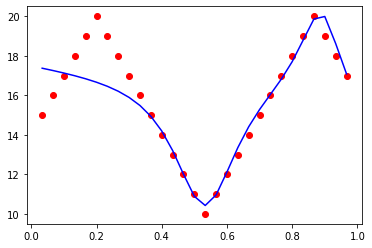

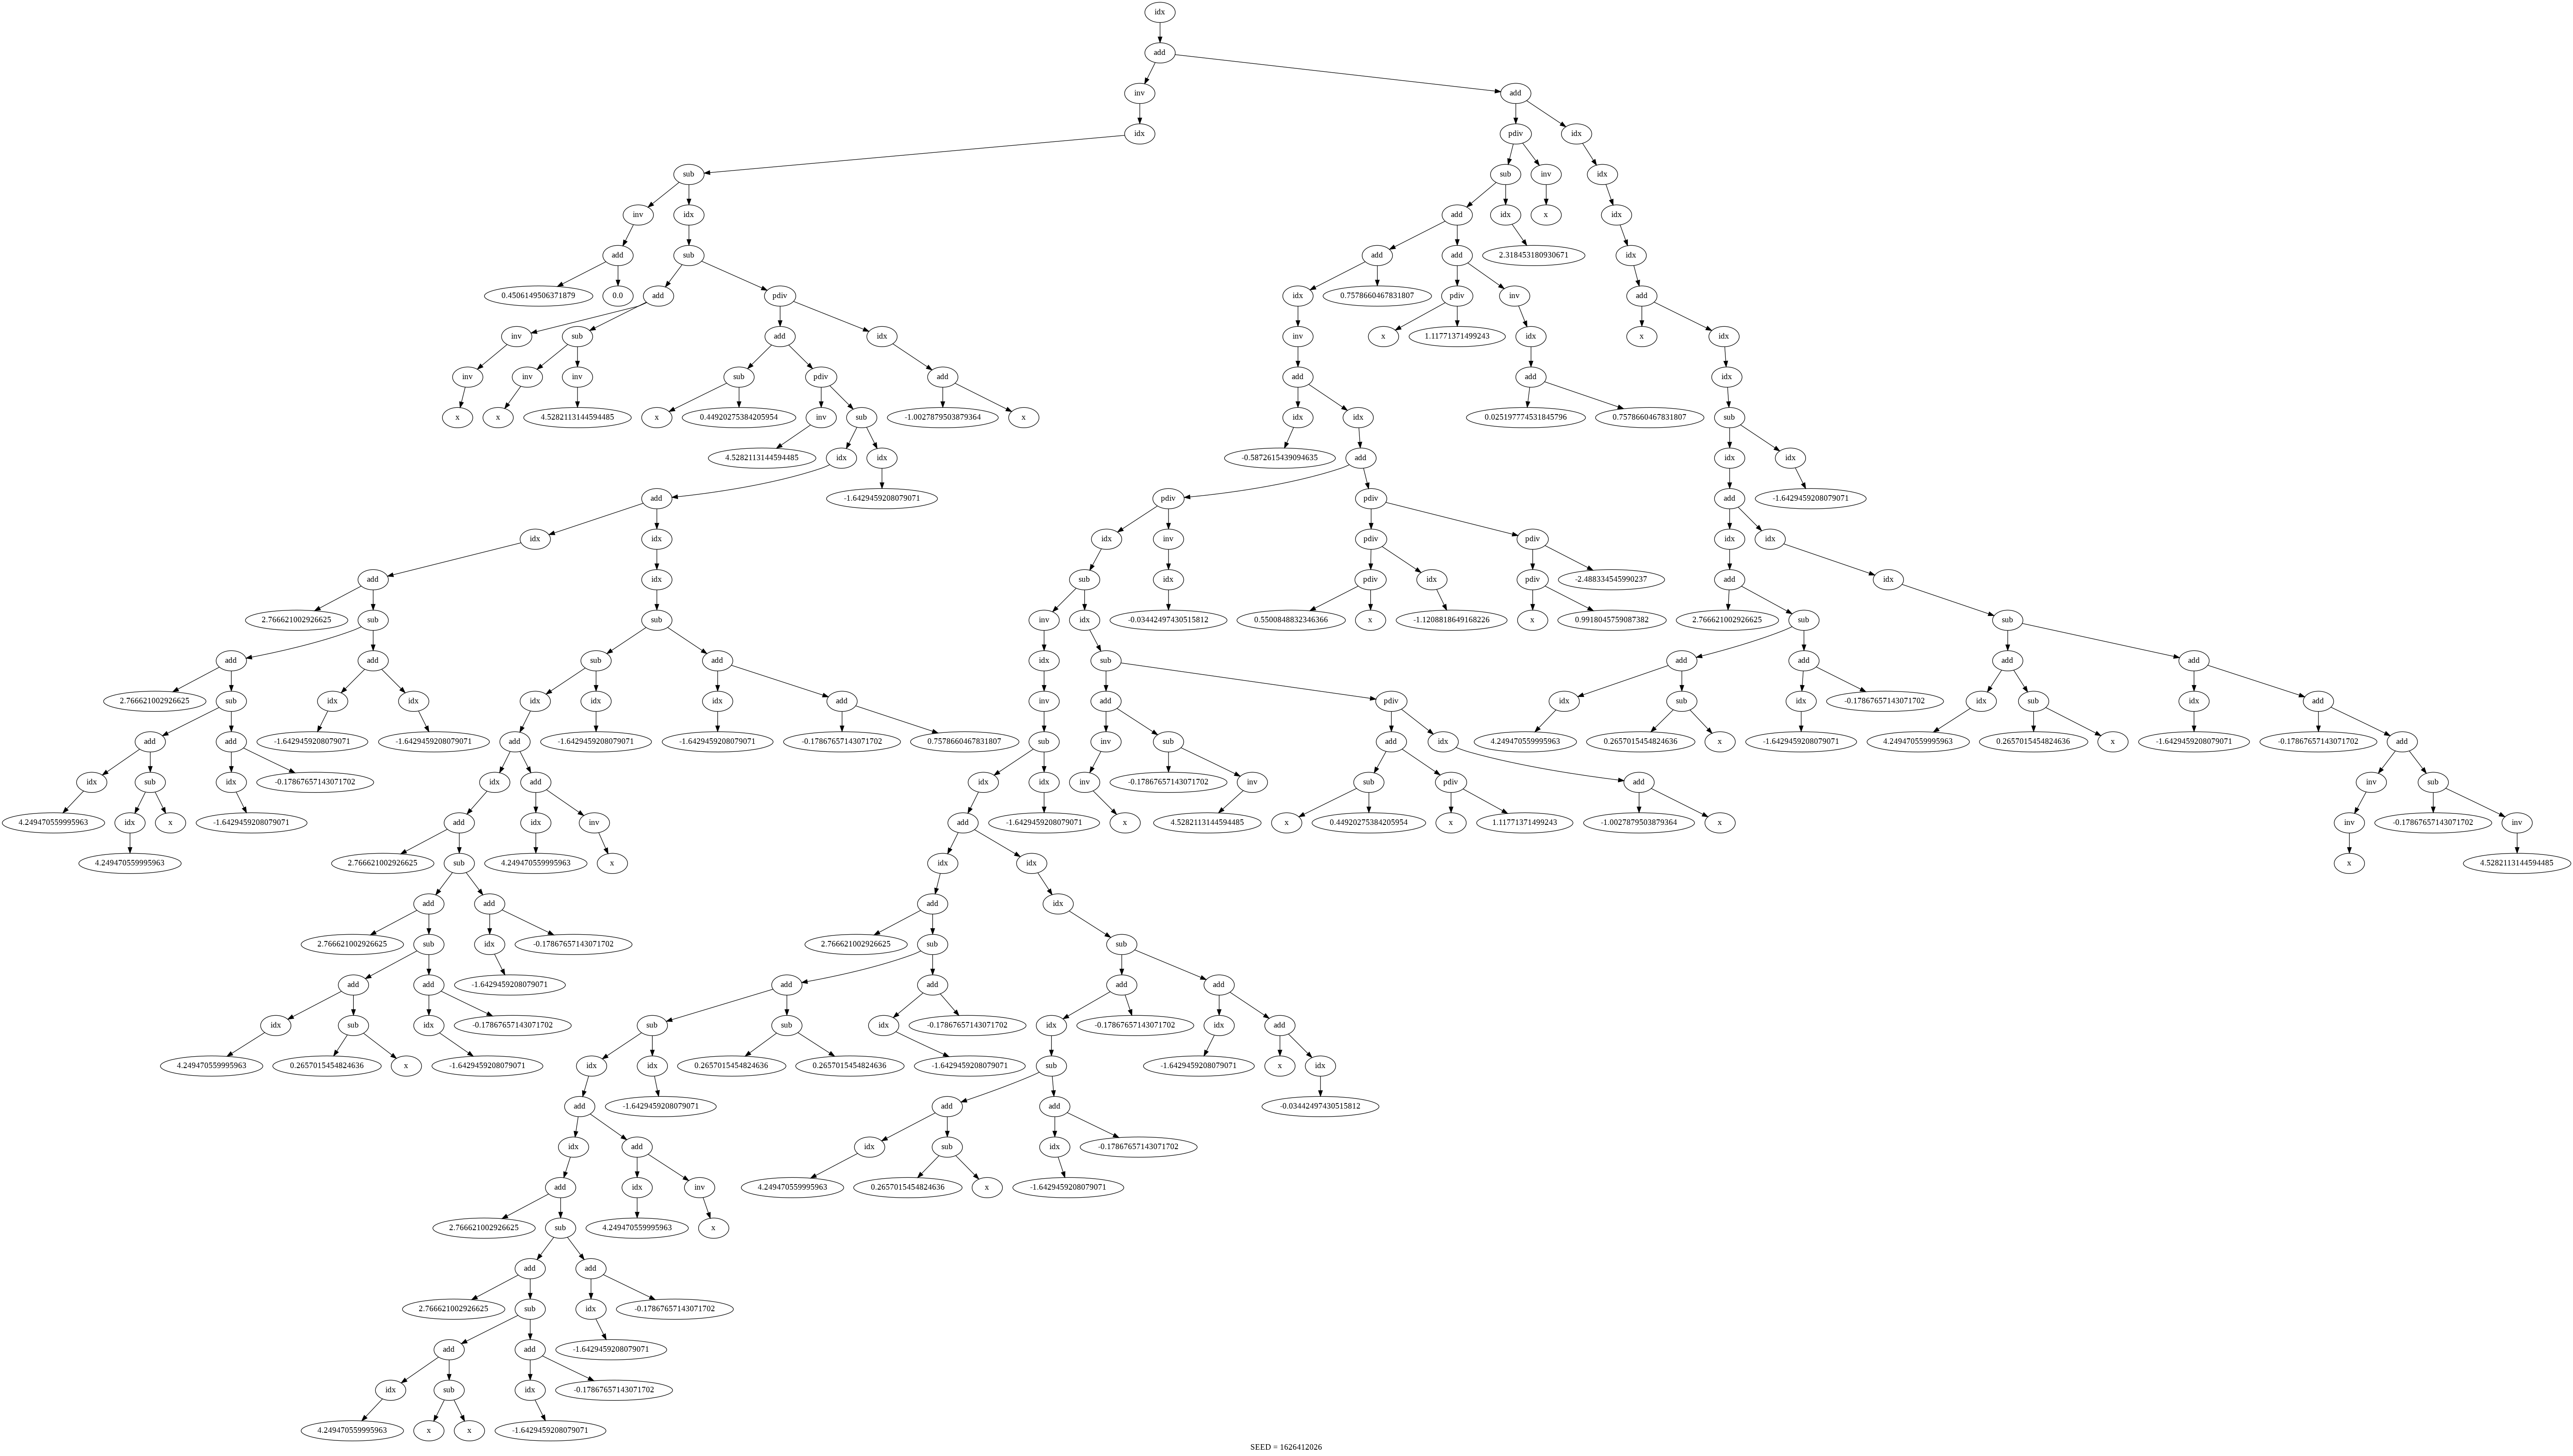

In [ ]:
# Set use initialization value of the pseudorandom generator (default is 0)
def init_random_seed(s = 0):
    if s != 0:  # if a specific non-zero value given, use it...
        rseed = s
    else:   # ...otherwise set a ``random'' initialization value (default)
        rseed = int(datetime.now().timestamp())
#        rseed = int(random.randrange(1<<32)+os.getpid())
    random.seed(rseed)
    # finally, return the initialization value (seed) which later allows us
    # to repeat promising runs
    return rseed

# The main program
def main():
    global SEED, DATASET

    if DATASET == []:
        DATASET = read_csv()
    rs = SEED # save the user defined seed value
    SEED = init_random_seed(SEED)

    solution = GP_run(DATASET, SEED)

    plot_solution(DATASET, solution, SEED)
    solution.draw_tree(str(SEED), 'SEED = %s' % str(SEED))

    # Restore the saved SEED value; if it was set to 0 in the user defined
    # parameters above, then this allows by just repeated running of the main
    # function to execute various independent evolutionary GP runs. If it was
    # non-zero, restarting main will allow reproducing a specific experiment
    # with this seed value.
    SEED = rs

if __name__== "__main__":
    main()